# Домашнее задание

На лекции мы разобрались, что ML-модели можно атаковать. Например, в задаче распознавания лиц мы можем добавить к изображению небольшой шум, который заставит модель совершить ошибку.

В этом задании мы научимся защищать модель от атак. Для иллюстрации мы будем использовать простую логистическую регрессию, но похожие идеи можно применить и к сложным нейросетям.

В качестве задачи рассмотрим классификацию изображений MNIST для цифр 0 и 1.



### Подготовка

In [ ]:
# Загрузим библиотеки, которые нам пригодятся

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Загрузим датасет
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

# подготовим данные в нужном формате
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

# Оставим в датасете только классы 0 и 1
y_bin = y[(y == 0) | (y == 1)]
X_bin = X[(y == 0) | (y == 1)]


# Для удобства, обозначим лейблы классов за -1 (обозначает цифру 0)
# и 1 (обозначает цифру 1)
y_bin[y_bin == 0] = -1

# Посмотрим на долю единиц в датасете
positive_class_size = len(y_bin[y_bin == 1])
positive_class_rate = positive_class_size / len(y_bin)

print("Доля единиц в датасете: ", positive_class_rate)

Доля единиц в датасете:  0.5329499323410013


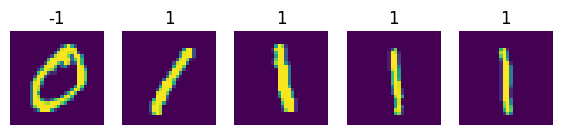

In [ ]:
# Посмотрим на первые 5 примеров

n = 5

fig, axs = plt.subplots(1, n, figsize=(7, 3))

for ax, image, label in zip(axs, X_bin[:n], y_bin[:n]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

### Шаг 1. Тренировка незащищенной модели [10 баллов]


Начнем с того, что натренируем стандартную модель логистической регрессии и оценим ее устойчивость к атакам. Из курса ML вспомним, что логистическая регрессия это линейная модель:

$$h_\theta(x) = w^T x + b$$

с функцией ошибки

\begin{equation}
\ell(h_\theta(x), y) = \log(1+\exp(-y\cdot h_\theta(x))) \equiv L(y \cdot h_\theta(x))
\end{equation}

Здесь для сокращения записи мы ввели функцию $L(x) = \log(1+\exp(-x))$.


**Что нужно сделать:**

1. Разбить данные на train и test

2. Нормализовать датасет ($X$) так, чтобы значения каждого пикселя были в диапазоне [0, 1]

3. Натренировать модель логистической регрессии на train set

4. Оценить точность (accuracy) логистической регрессии на test set

Для решения этой части задания можно использовать встроенные методы `sklearn`





### __Первый способ__ - Методы sklearn


In [ ]:
# Для решения могут пригодиться следующие методы

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Разбиваем данные
X_train,X_test,y_train,y_test = train_test_split(X_bin,y_bin,train_size=.3)


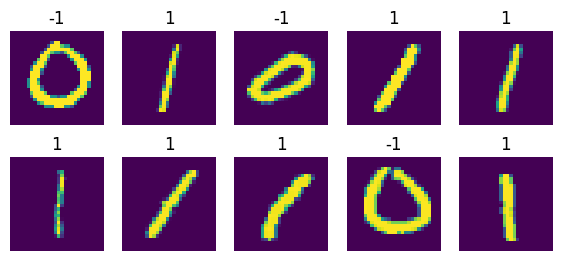

In [ ]:
# Демонстрация, что все ок
n = 5
fig, axs = plt.subplots(2, n, figsize=(7, 3))
## Train
for ax, image, label in zip(axs[0], X_train[:n], y_train[:n]):
  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)
  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")
## Test
for ax, image, label in zip(axs[1], X_test[:n], y_test[:n]):
    # Переводим картинку из вектора длины 784 в матрицу 28 x 28
    image_reshaped = image.reshape(28, 28)
    ax.imshow(image_reshaped)
    ax.set_title(label)
    ax.axis("off")

In [ ]:
# Нормализация данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_test_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.linear_model import LogisticRegression
# Инициализация предобученной модели
clf = LogisticRegression().fit(X_train_scaled,y_train)

In [ ]:
output = clf.predict(X_test_scaled)

print(f'''Точность {np.mean((output == y_test))}
Точность функцией из ski-learn {accuracy_score(y_test,output)}''')


Точность 0.9988401314517688
Точность функцией из ski-learn 0.9988401314517688


In [ ]:
len(X_train[0])

784

### __Второй способ__ - Собственная реализация алгоритма

Пусть лосс функция $L(x,Θ) = \frac{1}{n} \sum_{i=1}^n \log(1+\exp(-x_i))$, где $x_i=y_i \cdot h_\theta(x_i)=y_i \cdot \theta^T \cdot X_i$  
$X_i - изображение, y_i$ - класс изображения  

Тогда градиент будет выглядеть (пользуясь правилом дифф. сложной функции):
$\dfrac{\mathrm{d}L(x,Θ)}{\mathrm{d}Θ}=\frac{1}{n} \sum_{i=1}^n \dfrac{1}{1+exp(-x_i)} \cdot exp(-x_i) \cdot -(x_i)'_{\theta}=\frac{1}{n}\sum_{i=1}^nσ(x_i) \cdot exp(-x_i) \cdot (-yX_i)$

Примечание:
$(x_i)'_{\theta}=y_i (\cdot \theta^T \cdot X_i)'_{θ}=y_i \cdot (x^i_1\cdotΘ_1+x^i_2\cdotΘ_2+....x_d^i\cdotΘ_d)'_{\theta}=y_i\cdot X_i$

Далее используем обычную известную вычислительную схему:

Инцилизируем веса,  вектор  - $\theta_0 = (Θ^0_1 ...Θ^0_m...Θ^0_d)^T$ и дальше реализуется градиентный спуск, где веса обновляются согласно $θ_{k+1} = θ_k - \alpha \cdot grad L$

In [ ]:
def sigm(x):
    return 1 / (1 + np.exp(-x))

np.random.seed(25)

W = (np.random.random(784)).squeeze()

alpha = 0.1
loss_result = []
ar_result = []
h = np.vectorize(lambda x: 1 if x>=0 else -1)
N = 784
for i in range(40):
  grad = np.zeros(N)
  for X,y in zip(X_train_scaled,y_train):
    grad+=sigm(y*np.dot(X,W))*np.exp(-y*np.dot(X,W))*(-y*X)
  grad/=N
  #Grad descent
  W -= alpha * grad
  #Predict
  out = h(np.dot(X_train_scaled, W)).squeeze()
  #Loss
  loss = sum(np.log(1+np.exp(-y_train*np.dot(X_train_scaled, W))))/len(X_train_scaled)
  loss_result.append(loss)
  ar_result.append(np.mean(out == y_train))


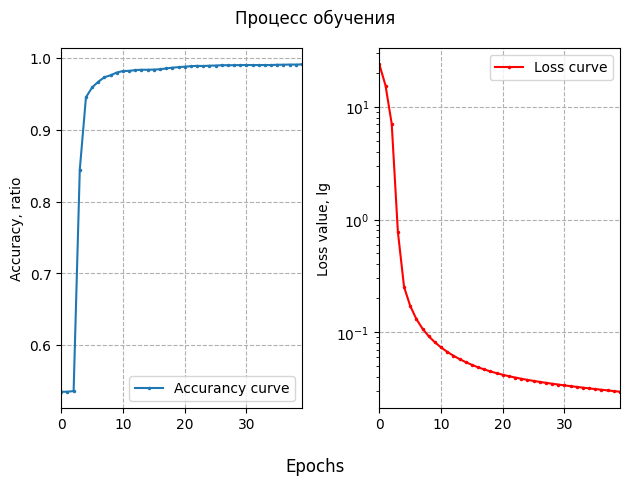

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2)
#
axes[0].plot(ar_result,label='Accurancy curve',marker='o',markersize=1.5)
axes[0].set_ylabel('Accuracy, ratio')

axes[1].plot(loss_result,label='Loss curve',c='r',marker='o',markersize=1.5)
axes[1].set_ylabel('Loss value, lg')
axes[1].set_yscale('log')

axes[0].grid(True,linestyle='--')
axes[1].grid(True,linestyle='--')
axes[0].legend()
axes[1].legend()
fig.supxlabel('Epochs')
plt.suptitle('Процесс обучения')
[ax.set_xlim([0,39]) for ax in axes]
fig.tight_layout()

Действительно, можно наблюдать, что точность с каждой эпохой увеличивались, а Loss функция минимизирована и находится на траектории убывания (согласно логике градиентного спуска).

In [ ]:
outputs = h(np.dot(X_test,W))
print('Точность на тесте, accurancy {}'.format(np.sum(outputs == y_test)/len(y_test)))

Точность на тесте, accurancy 0.9925575101488497


### Шаг 2. Атака незащищенной модели [15 баллов]

Будем считать, что мы можем атаковать модель, изменив значение каждого пикселя в изображении не более чем на 0.2 (атака производится после нормализации):

$$x' = x + \delta, \quad ||\delta||_{\infty} \le 0.2 = ɛ.$$

Как мы доказали на лекции, в случае логистической регрессии мы можем найти точное выражение для оптимальной атаки:
\begin{equation}
\delta^\star = - y \cdot \epsilon \cdot \mathrm{sign}(w),
\end{equation}
где $w$ это вектор весов модели, который мы получили на Шаге 1.

Давайте проведем атаку на модель и посмотрим как сильно упадет её точность.

**Что нужно сделать**

1. Вычислить значения оптимальной атаки $\delta^\star$ для каждого класса (-1 и 1)

2. Применить атаку к каждому изображению в test set

3. Оценить точность (accuracy) логистической регрессии на атакованном test set

Обратите внимание, что атака изображения может вывести значения пикселей из диапазона $[0, 1]$. Для простоты в этом задании можно не делать повторной нормализации.

Для решения этой части задания можно использовать встроенные методы `sklearn`

In [ ]:
eps = 0.12
# O - "-1"; 1 - "1"

attack=-y_test[:,np.newaxis]*np.sign(W)*eps
#
X_attacked=X_test_scaled+attack
h = np.vectorize(lambda x: 1 if x>=0 else -1)
outputs = h(np.dot(X_attacked, W)).squeeze()


In [ ]:
outputs = h(np.dot(X_attacked,W))
print('Точность на тесте, accurancy {}'.format(np.sum(outputs == y_test)/len(y_test)))


Точность на тесте, accurancy 0.002416392808815001


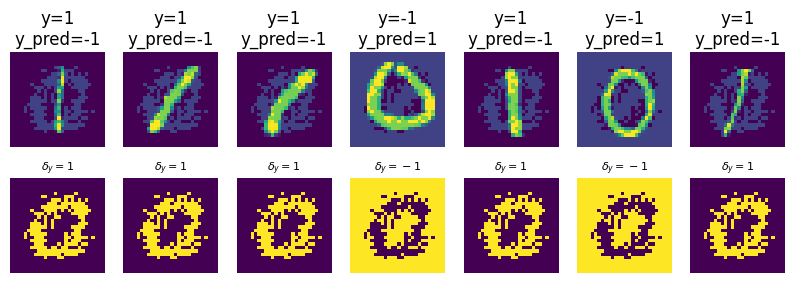

In [ ]:
# Демонстрация, что все ок
#
n = 7
fig, axs = plt.subplots(2, n, figsize=(10, 3))

predict = h(np.dot(X_attacked[:n],W))

## Train
for ax, image, label in zip(axs[0], X_attacked[:n], ['y={}\ny_pred={}'.format(f,p) for f,p in zip(y_test[:n],predict)]):
  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)
  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

## Attack
for ax, image, label in zip(axs[1], attack[:n], ['$\delta_y={}$'.format(y) for y in y_test[:n]]):
    # Переводим картинку из вектора длины 784 в матрицу 28 x 28
    image_reshaped = image.reshape(28, 28)
    ax.imshow(image_reshaped)
    ax.set_title(label,fontsize=8)
    ax.axis("off")


Аттака успешно сработала - изображения человеческому глазу отличимы, а модель - стала ошибаться. Точность уменьшилась и стала около 0.

### Шаг 3. Тренировка Robust Classifier [25 баллов]

Чтобы натренировать модель, устойчивую к атакам, нужно изменить процесс тренировки. Во время тренировки нам нужно минимизировать не стандартную функцию ошибки логистической регрессии, а модифицированную:

\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_1 \right ).
\end{equation}

Натренируйте модель Robust Logistic Regression на train set и оцените ее устойчивость к атакам.

**Что нужно сделать:**

1. Реализуйте свой ML-метод: класс **RobustLogisticRegression**, который наследует от sklearn класса [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html). Новый класс должен содержать методы `fit` и `predict`, а внутри метода `fit` должна проходить процедура градиентного спуска с новой функцией ошибки. Шаблон класса дан ниже.

2. Натренируйте Robust Logistic Regression и оцените ее точность на чистом test set

3. Вычислите атаку $\delta^\star = - y \cdot \epsilon \cdot \mathrm{sign}(w)$ на модель и проатакуйте test set. Для атаки используйте веса робастной модели

4. Оцените точность модели на атакованном test set

Для решения этой части задания **нельзя** использовать встроенные методы `sklearn`, только шаблон ниже и методы `numpy`

In [ ]:

from sklearn.base import BaseEstimator
class RobustLogisticRegression(BaseEstimator):
    def __init__(self,eps=0.2,alpha=0.001):
        super(BaseEstimator, self).__init__()
        self.ar_result=[]
        self.W = (2*np.random.random(784)-1).squeeze()
        self.eps = eps
        self.h = np.vectorize(lambda x: 1 if x>=0 else -1)
        self.alpha=alpha
    def fit(self, X, y,epochs=10):
        N = X.shape[1]
        """Метод для тренировки модели по тренировочным данным X и y"""
        accurancy=0.
        for i in range(epochs):
            grad = np.zeros(N)
            for x_,y_ in zip(X,y):
              exp = np.exp(self.eps * np.linalg.norm(self.W, ord=1)  - y_ * np.dot(self.W, x_))
              grad += exp / (1 + exp) * (eps * self.h(self.W) - y_ * x_)
            grad /= N
            self.W -= alpha * grad
            output = h(np.dot(X, self.W)).squeeze()
            accurancy=sum(output == y)/len(y)
            self.ar_result.append(accurancy)
        return self.ar_result
    def attack(self,y):
      return -y[:,np.newaxis]*np.sign(self.W)*self.eps
    def plot(self,title=True):
      plt.plot(self.ar_result,label='Accurancy curve',marker='o',markersize=1.5)
      plt.grid(True,linestyle='--')
      plt.xlim([0,len(self.ar_result)-1])
      plt.ylim([min(ar_result),1.01])
      if title:
        plt.title(r'Обучение модели за {} epochs, $\alpha={},\epsilon={}$'.format(len(self.ar_result),self.alpha,self.eps))
        plt.ylabel('Accuracy, ratio')
        plt.xlabel('Epochs')
        plt.legend()
      else:
        plt.title(r'$\epsilon$={}'.format(self.eps))
      plt.axhline(y=1.0,c='r',linestyle='--',linewidth=0.5)
    def predict(self, X):
        """Метод для предсказания классов для данных X"""
        return h(np.dot(X,W))

__Комментарий к решению__:
Вспомним пункт 1, где было реализовано собственное решение.  
Теперь необхоидмо пересчитать производную новой loss-функции.

$\dfrac{\mathrm{d}L(x,Θ)}{\mathrm{d}Θ}=\frac{1}{n} \sum_{i=1}^n \dfrac{1}{1+exp(-x_i+\epsilon\cdot\|θ\|_1)} \cdot exp(-x_i+\epsilon\cdot\|θ\|_1) \cdot (-x_i+\epsilon\cdot\|θ\|_1)'_{\theta}=\frac{1}{n}\sum_{i=1}^nσ(x_i-\epsilon\cdot\|θ\|_1) \cdot exp(-x_i+\epsilon\cdot\|θ\|_1) \cdot (-x_i+\epsilon\cdot\|θ\|_1)'_{\theta}$

Примечание:  

$(-x_i+\epsilon\cdot\|θ\|_1)'_{\theta}=(-y_i\theta^T \cdot X_i+\epsilon\cdot\|θ\|_1)'_{θ}=(-x^i_1y_i\cdotΘ_1+\epsilon|Θ_1|-...-x_d^iy_i\cdotΘ_d+\epsilon|Θ_d|)'_{\theta}=(*)$

------
$|Θ_i|=
\begin{cases}
      Θ_i, Θ_i > 0;
      -Θ_i, Θ_i < 0
    \end{cases} =>
|Θ_i|'_Θ=
\begin{cases}
      1, Θ_i > 0;
      -1, Θ_i < 0
    \end{cases}$


---


$(*)=-x^i_1y_i+\epsilon|θ_1|'_{θ}+...=-y_iX_i+\epsilon\cdot m(Θ)$ , где
$m(Θ)=|\theta_i|'_{\theta}$


Таким образом, градиент loss функции.

$\dfrac{\mathrm{d}L(x,Θ)}{\mathrm{d}Θ}=\frac{1}{n} \sum_{i=1}^n \frac{exp(-x_i+\epsilon\cdot\|θ\|_1)}{1+exp(x_i-\epsilon\cdot\|θ\|_1} \cdot (\epsilon \cdot m(θ) - y_iX_i)$



Из предположения, что $Θ_i$ не станут зануляться (чтобы это можно было дифференцировать).

Дальнейшее решение, аналогично, заключается в градиетном спуске (где градиент станет антиградиентом, что учтено в вычислительной схеме).

In [ ]:
model = RobustLogisticRegression(eps=0.2,alpha=0.1)
accurancy = model.fit(X_train_scaled,y_train,epochs=8)

In [ ]:
accurancy

[0.9276048714479026,
 0.9903022101939558,
 0.9925575101488497,
 0.993234100135318,
 0.9945872801082544,
 0.995489400090212,
 0.9952638700947226,
 0.9948128101037438]

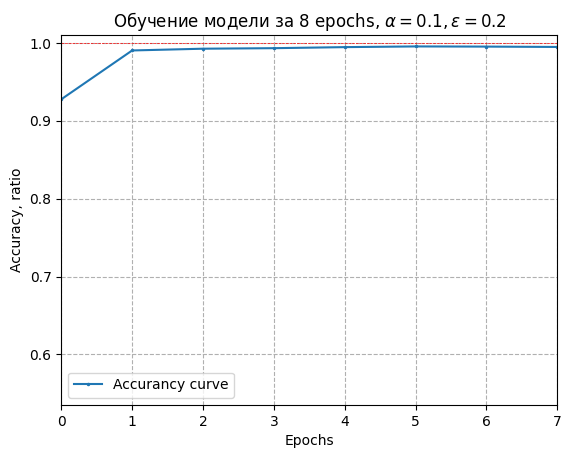

In [ ]:
model.plot()

In [ ]:
X_attacked_r=X_test_scaled+np.sign(model.W)*model.eps*-y_test[:,np.newaxis]
print('Точность на чистом тесте, accurancy {}\nТочность на атакованом тесте, accurancy {}'.format(np.sum(model.predict(X_test_scaled) == y_test)/len(y_test),np.sum(model.predict(X_attacked_r) == y_test)/len(y_test)))

Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.5166247825246472


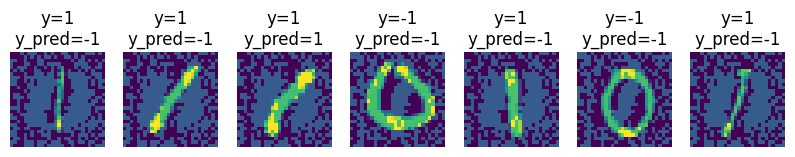

In [ ]:
## Test
n = 7
fig, axs = plt.subplots(ncols=n, figsize=(10, 3))

predict = h(np.dot(X_attacked_r,W)[:n])

for ax, image, label in zip(axs, X_attacked_r[:n], ['y={}\ny_pred={}'.format(f,p) for f,p in zip(y_test[:n],predict)]):
  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)
  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

Как можно видеть аттака искажает картинки, но это не влияет на робстаные предсказания

eps=0.02
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.989367871641214
eps=0.05
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.9847283974482892
eps=0.06
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.9858882659965204
eps=0.09
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.9331142470520007
eps=0.11
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.8813067852310071
eps=0.15
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.9450028996713706
eps=0.17
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на атакованом тесте, accurancy 0.7611637347767253
eps=0.2
________
Точность на чистом тесте, accurancy 0.989851150202977
Точность на а

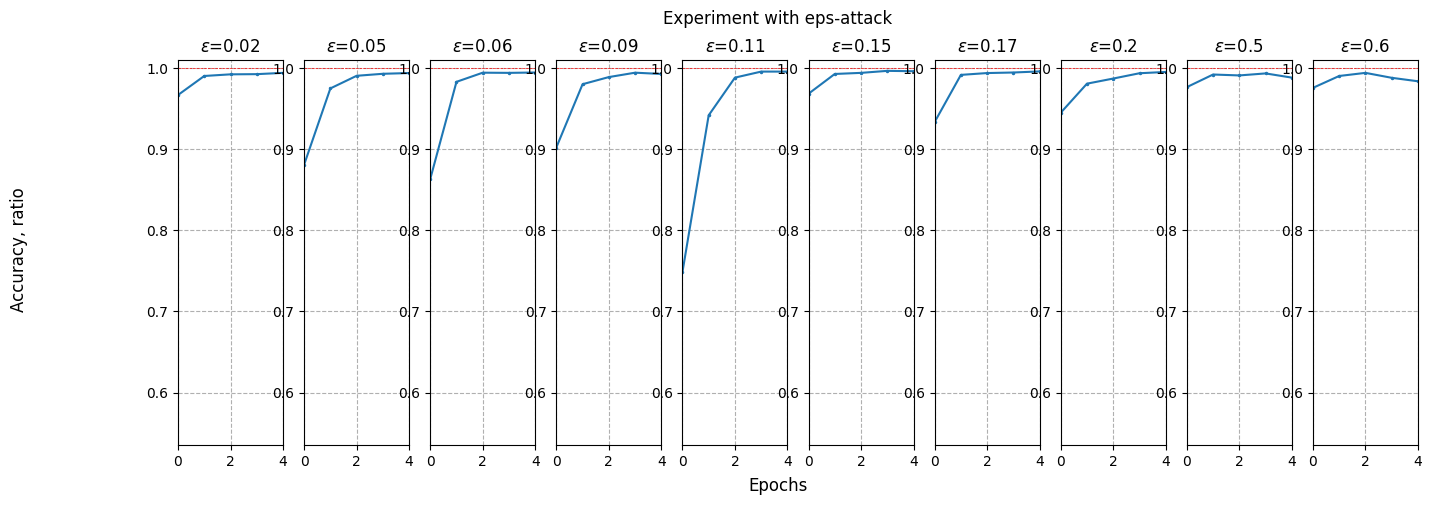

In [ ]:
eps_attack = [0.02,0.05,.06,.09,.11,.15,.17,.2,.5,.6]

fig,axes = plt.subplots(ncols=len(eps_attack),figsize=(16,5))
fig.suptitle('Experiment with eps-attack')

for eps,ax in zip(eps_attack,axes):
  model = RobustLogisticRegression(eps=eps,alpha=0.1)
  model.fit(X_train_scaled,y_train,epochs=5)
  X_attacked_r=X_test_scaled+np.sign(model.W)*model.eps*-y_test[:,np.newaxis]
  plt.sca(ax)
  model.plot(title=False)
  print('eps={}\n________\nТочность на чистом тесте, accurancy {}\nТочность на атакованом тесте, accurancy {}'.format(eps,np.sum(model.predict(X_test_scaled) == y_test)/len(y_test),np.sum(model.predict(X_attacked_r) == y_test)/len(y_test)))
fig.supylabel('Accuracy, ratio')
fig.supxlabel('Epochs')
plt.show()
fig.tight_layout()

#__Выводы__
Таким образом, получилось:
- обучить логистическую регрессию на классы -1 и 1 с помощью своего градиентного спуска
- выполнить атаку по модели, значительно испортив точность предсказаний модели

  - 0.9925 vs 0.0024, чистый test и атакованный test соотвественно

- создать робастную модель, используя модифированную loss функцию, предварительно вычислив градиент этой самой функции
  - Были использованы различные eps-атаки, можно наблюдать, что при всех изменниях, что были рассмотрены, робастная модель показывает отличные показатели точности, а где это нет - возможно модель недообучилась и нужно было больше эпох обучения

  **Выполнил:** Кимельфельд Дмитрий, студент 4 курса СПбПУ

  **tg: @kumelfeld**

